# Sex differences in somatic-germ crosstalk
## D. Plots

In [1]:
library(dplyr)
library(reshape2)
library(plyr)
library(RColorBrewer)
library(ggplot2)
library(pheatmap)
library(cowplot)



get_cells2genes = function(CPresults, genes2filter = NULL, show_only_selected = F){
    if( ! is.null(genes2filter) ){
        idx = sapply(rownames(CPresults), function(x) any(unlist(Int2Gene[[x]]) %in%  genes2filter) )
        message(sum(idx), ' interactions')             
        CPresults = CPresults[ idx, ]
        CPresults = CPresults[ , apply(CPresults, 2, sum) > 0]
    }
    # reformat as dataframe                                    
    df = melt(as.matrix(CPresults))
    df$cellphoneDB_hit = df$value                 
    if (show_only_selected) # this is to show only expression values if int selected by cellphoneDB
        df = subset(df, cellphoneDB_hit == 1)
    # extract interaction partners
    xA = apply(df, 1, function(x){
        int = data.frame()
        for( i in Int2Gene[[x[1]]]$partner_a)
            for (pa in Int2Gene[[x[1]]]$partner_b){
                toadd = data.frame(cell = strsplit(x[2], '--')[[1]][1],
                           gene = i,
                           interaction = x[1], 
                           partner = strsplit(x[2], '--')[[1]][2],
                           partner_gene = pa,
                           cellphoneDB_hit = x[length(x)],
                           row.names = NULL)
                int = rbind(int, toadd)
                }
        return(int)
    })
    xB = apply(df, 1, function(x){
        int = data.frame()
        for( i in Int2Gene[[x[1]]]$partner_b)
            for (pa in Int2Gene[[x[1]]]$partner_a){
                toadd = data.frame(cell = strsplit(x[2], '--')[[1]][2],
                           gene = i,
                           interaction = x[1], 
                           partner = strsplit(x[2], '--')[[1]][1],
                           partner_gene = pa,
                           cellphoneDB_hit = x[length(x)],
                            row.names = NULL)
                int = rbind(int, toadd)
                }
        return(int)
    })
    x = append(xA, xB)
    # Merge as data frame for plotting with ggplot
    cells2genesCP = melt(x, id.vars = names(x[[1]]))
    cells2genesCP = unique(cells2genesCP[,-7])
#     # transfer expression info                                  
    cells2genesCP$id = paste(cells2genesCP$cell, cells2genesCP$gene)
    cells2genesCP$id_partner = paste(cells2genesCP$partner, cells2genesCP$partner_gene)
    cells2genesCP$AveExpr_cluster =  AVG$avg[ match(cells2genesCP$id, AVG$id) ]
    cells2genesCP$percentExpr_cluster =  PERC$percent[ match(cells2genesCP$id, PERC$id) ] 
    cells2genesCP$partner_AveExpr_cluster =  AVG$avg[ match(cells2genesCP$id_partner, AVG$id) ]
    cells2genesCP$partner_percentExpr_cluster =  PERC$percent[ match(cells2genesCP$id_partner, PERC$id) ] 

    return(cells2genesCP)
}
    
                                      
                                      
get_combinations_of_interest = function(Atype, Btype){
    all_celltypes = c(Atype, Btype)
    # Get all pairwise cluster combinations: A--B, B--A
    cluster_combinations = combn(all_celltypes, 2, simplify = T)

    # add self interactions
    cluster_combinations = cbind(sapply(all_celltypes, function(x) rep(x, 2) ), cluster_combinations)


    # We only want to test pairs including at least one cluster in Atype and Btype
    keepA = apply(cluster_combinations, 2, function(x) any(x %in% Atype))
    keepB = apply(cluster_combinations, 2, function(x) any(x %in% Btype))
    cluster_combinations = cluster_combinations[, keepA & keepB]

    # # We only want to test pairs including at least one cluster named 'media'
    # keep = apply(cluster_combinations, 2, function(x) any(x %in% 'Media'))
    # cluster_combinations = cluster_combinations[, keep]
    # ncol(cluster_combinations)

    # Consider the reverse interaction too: A--B but B--A as well
    cluster_combinations = cbind(cluster_combinations, cluster_combinations[2:1,]) %>% t(.) %>% unique(.)  %>% t(.) 

    # Make cluster pair labels: celltypeA--celltypeB             
    cluster_combinations_labels = apply(cluster_combinations, 2, paste, collapse = '--')
    ncol(cluster_combinations)

    colnames(cluster_combinations) = cluster_combinations_labels
}
                  
get_receptors2TF = function(CPresults, genes2filter = NULL, show_only_selected = F){
                     
    if( ! is.null(genes2filter) ){
        idx = sapply(rownames(CPresults), function(x) any(unlist(Int2Gene[[x]]) %in%  genes2filter) )
        message(sum(idx), ' interactions')             
        CPresults = CPresults[ idx, ]
        CPresults = CPresults[ , apply(CPresults, 2, sum) > 0]
    }
    # reformat as dataframe                                    
    df = melt(as.matrix(CPresults))
    df$cellphoneDB_hit = df$value                 
    if (show_only_selected) # this is to show only expression values if int selected by cellphoneDB
        df = subset(df, cellphoneDB_hit == 1)
    # extract interaction partners
    xA = apply(df, 1, function(x){
        int = data.frame()
        for( i in Int2Gene[[x[1]]]$partner_a)
            for (pa in Int2Gene[[x[1]]]$partner_b){
                toadd = data.frame(cell = strsplit(x[2], '--')[[1]][1],
                           gene = i,
                           member_of = Int2Gene[[x[1]]]$nameA,
                           interaction = x[1], 
                           partner = strsplit(x[2], '--')[[1]][2],
                           partner_gene = pa,
                           cellphoneDB_hit = x[length(x)],
                           row.names = NULL)
                int = rbind(int, toadd)
                }
        return(int)
    })
    xB = apply(df, 1, function(x){
        int = data.frame()
        for( i in Int2Gene[[x[1]]]$partner_b)
            for (pa in Int2Gene[[x[1]]]$partner_a){
                toadd = data.frame(cell = strsplit(x[2], '--')[[1]][2],
                           gene = i,
                           member_of = Int2Gene[[x[1]]]$nameB,
                           interaction = x[1], 
                           partner = strsplit(x[2], '--')[[1]][1],
                           partner_gene = pa,
                           cellphoneDB_hit = x[length(x)],
                            row.names = NULL)
                int = rbind(int, toadd)
                }
        return(int)
    })
    x = append(xA, xB)
    # Merge as data frame for plotting with ggplot
    cells2genesCP = melt(x, id.vars = names(x[[1]]))
    cells2genesCP = unique(cells2genesCP[,-8])
                     
                     
    # transfer expression info                                  
    cells2genesCP$id = paste(cells2genesCP$cell, cells2genesCP$gene)
    cells2genesCP$AveExpr_cluster =  AVG$avg[ match(cells2genesCP$id, AVG$id) ]
    cells2genesCP$percentExpr_cluster =  PERC$percent[ match(cells2genesCP$id, PERC$id) ] 
    # Filter Receptors with TFs
    R_with_TF = subset(cells2genesCP, member_of %in% names(R2TF) & AveExpr_cluster > 0)
    if( nrow(R_with_TF) == 0)
        return(NULL)
    # Add each TF into the data frame - note more than one TF per R
    R_to_TF_df = apply(R_with_TF, 1, function(xx) { as.data.frame(t(sapply(R2TF[[xx[3]]], function(tf, xx)  c(xx, TF=tf) , xx))) } )
    R_to_TF_df = melt(R_to_TF_df, id.vars = names(R_to_TF_df[[1]]) ) 
    R_to_TF_df = unique(R_to_TF_df[, c('cell', 'member_of', 'interaction', 'partner', 'cellphoneDB_hit', 'TF')]) 
    # Add differential TFact p-value
    R_to_TF_df = cbind(R_to_TF_df, TFact_df[paste(R_to_TF_df$cell, R_to_TF_df$TF) , ])
    R_to_TF_df = subset(R_to_TF_df, ! is.na(p_val) )
    return(R_to_TF_df)
}


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


------------------------------------------------------------------------------

You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)

------------------------------------------------------------------------------


Attaching package: ‘plyr’


The following objects are masked from ‘package:dplyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize




In [2]:
# Define variables
filter_int_user_curated = T #Use only user_curated interactions?
per_cutoff = 0.1 # min % of cells in the cluster required  with expression > 0 for the gene
pval_cutoff = 0.001 # max adjusted p-value requeired to consider a gene as DEG
logFC_cutoff = 0.2 # min logFC to consider a gene as DEG

# Load Microenviroments

In [3]:
germs = rev(c('PGC_mitotic', 
          'PGC', 
          'oogonia_STRA8', 'oogonia_meiosis', 'oocyte',
         'pre-spermatogonia'))
somaF = c( 'coelEpi', 'sKITLG','sLGR5_female',
          'ovarianSurf', 'preGC_II', 'preGC_II_hypoxia', 'preGC_III', 'preGC_III_Notch', 'preGC_I_OSR1')
somaM = c('sPAX8m',
    'Sertoli', 'Sertoli_WFDC2', 
            'sLGR5_male' )
somaB = c('coelEpi', 'sKITLG',
         'sPAX8b')
soma = c(somaM, somaB, somaF)


micro_df = read.csv('cellphoneDB/input/microenviroments/microenviroments.csv', stringsAsFactors = F)
microenviroments = split(micro_df, micro_df$microenviroment)  %>%  sapply(., select, celltype)
names(microenviroments) = gsub('.celltype', '', names(microenviroments))

# Load Cellphone Genes

In [4]:
# Load cellphone database - genes and complexes file
# Gene names
genes_cpDB = read.delim('~/gonads/scRNAseq_analysis_FCA_2sex/cellphoneDB/hsa_uniprot.txt', stringsAsFactors = F, sep = '\t')

# Complexes members
com_cpDB = read.csv('~/gonads/scRNAseq_analysis_FCA_2sex/cellphoneDB/database/complex_curated_032021.tsv', stringsAsFactors = F, sep='\t')
com_cpDB = unique(com_cpDB)
com_cpDB$complex_name = paste0('complex:', com_cpDB$complex_name)
# Generate complexes2gene symbol dictionary
Com2Gene = lapply(com_cpDB$complex_name, function(cx) subset(genes_cpDB, uniprot %in% unlist(com_cpDB[com_cpDB$complex_name == cx, 2:5]) )$gene_name )
Com2Gene = lapply(Com2Gene, unique)
names(Com2Gene) = com_cpDB$complex_name
                  
# Load interactions from cellphoneDB/out/means.txt output file                   
int_cpDB = read.delim('~/gonads/scRNAseq_analysis_FCA_2sex/cellphoneDB/bothSex/out/means.txt', stringsAsFactors = F)[, 1:10]
# MANDATORY: remove "curated" because we have cleaned and renamed them (this is a long story, just do it)
int_cpDB = subset(int_cpDB, annotation_strategy != 'curated')
# OPTIONAL: Use only user_curated interactions?
if(filter_int_user_curated)
    int_cpDB = subset(int_cpDB, annotation_strategy == 'user_curated')
# Generate Int2Gene dictionary
Int2Gene = apply(int_cpDB, 1, function(int) {
    int = unname(int)
    if(int[5] == ''){ # if partnerA is complex, then retrieve members from dictionary
       partnerA = Com2Gene[[int[3]]]
        nameA = gsub('complex:', '', int[3])
    }else{  # if partnerA is a single gene, take name from file
       partnerA = int[5]
        nameA=int[5]
    }
    if(int[6] == ''){  # if partnerB is complex, then retrieve members from dictionary
       partnerB = Com2Gene[[int[4]]]
        nameB = gsub('complex:', '', int[4])
    }else{  # if partnerB is a single gene, take name from file
       partnerB = int[6]
        nameB=int[6]
        }
    list(partner_a=partnerA,partner_b=partnerB, nameA = nameA, nameB=nameB )
    }) 
names(Int2Gene) = int_cpDB$interacting_pair
                  
# Load R-TFs  
R2TF_df = read.csv('~/gonads/main/cellphoneDB/database/R2TF_interactions_curated.csv', stringsAsFactors = F, sep=',')
R2TF = lapply(unique(R2TF_df$Receptor), function(re) subset(R2TF_df, Receptor==re)$TF )
names(R2TF) = unique(R2TF_df$Receptor)

## Load cellphone results file

In [5]:
CPresults = read.csv(paste0('cellphoneDB/out/interactions_' , pval_cutoff, '_logFC', logFC_cutoff, '.csv'), stringsAsFactors = F)
rownames(CPresults) = CPresults$X
CPresults = CPresults[, -1]
colnames(CPresults) = gsub('\\...', '--', colnames(CPresults))
head(CPresults)[, 1:5]

,PGC--PGC,PGC_mitotic--PGC_mitotic,coelEpi--coelEpi,ovarianSurf--ovarianSurf,preGC_II--preGC_II
,<int>,<int>,<int>,<int>,<int>
22Hydroxycholesterol_byCYP11A1_NR1H4,0,0,0,0,0
Androsterone_byHSD17B6_NR1H4,0,0,0,0,0
2arachidonoylglycerol_byDAGLB_CNR1,0,0,0,0,0
FN1_integrin_a4b1_complex,0,0,0,0,0
PLAUR_integrin_a4b1_complex,0,0,0,0,0
JAM2_integrin_a4b1_complex,0,0,0,0,0


# Load TF activities

In [6]:
# load TF activities  info
# you need to put in a folder the DE files of the clusters that you're interested in
# The file must contain at least four columns (aka, you can reuse the output of the DEG files):
# - Gene: TF name
# - cluster: cell type
# - adj.P.Val: adjusted p-value from the DE test
# - logFC: from the DE test
path_TFacts = 'cellphoneDB/input/TFacts/merged.csv'


# Load
TFact_df = read.csv(path_TFacts, stringsAsFactors = F) %>%
        filter(., p_val_adj < pval_cutoff) %>%
        filter(., avg_log2FC > logFC_cutoff)
TFact_df$gene =  strsplit(TFact_df$gene, '-[A-E]') %>% sapply(., head, 1)
rownames(TFact_df) =  paste(TFact_df$cluster, TFact_df$gene)


# Build dictionary clusters2expressed genes
clusters = unique(TFact_df$cluster)
is_TFact = lapply(clusters, function(cl){
    filter(TFact_df, cluster == cl)$gene
})
names(is_TFact) = clusters
names(is_TFact) 

[1] "oocyte"            "oogonia_meiosis"   "PGC_mitotic"      
 [4] "PGC"               "oogonia_STRA8"     "pre-spermatogonia"
 [7] "GC_mitotic"        "coelEpi"           "ovarianSurf"      
[10] "preGC_II_hypoxia"  "Sertoli_WFDC2"     "Sertoli"          
[13] "FetalLeydig-like"  "sPAX8b"            "sKITLG"           
[16] "preGC_III_Notch"   "sPAX8m"            "preGC_III"        
[19] "preGC_II"          "preGC_I_OSR1"      "sLGR5_female"     
[22] "sLGR5_male"

# Load expression information

In [7]:
# load DE expression info
# you need to put in a folder the DE files of the clusters that you're interested in
# The file must contain at least four columns (aka, you can reuse the output of the DEG files):
# - Gene: gene symbol
# - cluster: cell type
# - adj.P.Val: adjusted p-value from the DE test
# - logFC: from the DE test
path_DEGs = 'cellphoneDB/input/DEGs/merged.csv'


# Load
DE_df = read.csv(path_DEGs, stringsAsFactors = F) %>%
        filter(., gene %in% genes_cpDB$gene_name) %>%
        filter(., p_val_adj < pval_cutoff) %>%
        filter(., avg_logFC > logFC_cutoff)
        


# Build dictionary clusters2expressed genes
clusters = unique(DE_df$cluster)
is_DE = lapply(clusters, function(cl){
    filter(DE_df, cluster == cl)$gene
})
names(is_DE) = clusters

In [8]:
# Load percentage expressions
path_Per = 'cellphoneDB/input/percent.csv'


# Load
Per_mat = read.csv(path_Per, stringsAsFactors = F, row.names = 1) 
Per_df = setNames(melt(as.matrix(Per_mat), factorsAsStrings = T), c('gene', 'cluster', 'percent'))


# Filetr expressed
# Per_df = subset(Per_df, percent >= per_cutoff)
Per_df = Per_df[ order(Per_df$gene), ]

# Build dictionary clusters2expressed genes                       
PERC = Per_df
PERC$id = paste(PERC$cluster, PERC$gene)                      
head(PERC)

,gene,cluster,percent,id
,<fct>,<fct>,<dbl>,<chr>
1,MIR1302-2HG,PGC,0,PGC MIR1302-2HG
28231,MIR1302-2HG,PGC_mitotic,0,PGC_mitotic MIR1302-2HG
56461,MIR1302-2HG,Sertoli,0,Sertoli MIR1302-2HG
84691,MIR1302-2HG,Sertoli_WFDC2,0,Sertoli_WFDC2 MIR1302-2HG
112921,MIR1302-2HG,coelEpi,0,coelEpi MIR1302-2HG
141151,MIR1302-2HG,oocyte,0,oocyte MIR1302-2HG


In [9]:
# Load average expressions
path_Exp = 'cellphoneDB/input/average_log.csv'

# Load
Avg_mat = read.csv(path_Exp, stringsAsFactors = F, row.names = 1) 
Avg_mat = Avg_mat[, colnames(Avg_mat) %in% c(germs, soma)]
# scale within lineages
cn = colnames(Avg_mat)
Avg_matG =  apply(Avg_mat[ ,  colnames(Avg_mat) %in%  germs],1,scale) %>% t(.)
colnames(Avg_matG) = intersect(colnames(Avg_mat), germs)
Avg_matS =  apply(Avg_mat[ ,  colnames(Avg_mat) %in%  soma],1,scale) %>% t(.)
colnames(Avg_matS) = intersect(colnames(Avg_mat), soma)
# Avg_matSf =  apply(Avg_mat[ , somaF],1,scale) %>% t(.)
# Avg_matSm =  apply(Avg_mat[ , somaM],1,scale) %>% t(.)
# Avg_mat = cbind(Avg_matG, Avg_matSf, Avg_matSm)
Avg_mat = cbind(Avg_matG, Avg_matS)
# colnames(Avg_mat) = cn

# convert into a data frame for plotting
Avg_df = setNames(melt(as.matrix(Avg_mat), factorsAsStrings = T), c('gene', 'cluster', 'avg'))
# Filetr expressed
Avg_df = Avg_df[ order(Avg_df$gene),  ]

# Build dictionary clusters2expressed genes                       
AVG = Avg_df
AVG$id = paste(AVG$cluster, AVG$gene)                      
head(AVG)

,gene,cluster,avg,id
,<fct>,<fct>,<dbl>,<chr>
1,MIR1302-2HG,PGC,-0.02618699,PGC MIR1302-2HG
28231,MIR1302-2HG,PGC_mitotic,-0.49296624,PGC_mitotic MIR1302-2HG
56461,MIR1302-2HG,oocyte,-0.86400380,oocyte MIR1302-2HG
84691,MIR1302-2HG,oogonia_STRA8,1.70479969,oogonia_STRA8 MIR1302-2HG
112921,MIR1302-2HG,oogonia_meiosis,-0.32164266,oogonia_meiosis MIR1302-2HG
141151,MIR1302-2HG,Sertoli,0.21786701,Sertoli MIR1302-2HG


# PLOT cortex

In [10]:
germ_partners = c( 'ACVR2B', 'BMPR1A', 'IGF1R', 'PTGES2', 'PTGES3', 
                 'PDGFB', 
#                   'WNT2B',
                  'PNMT',
                  'EFNA4','EPHB4',
                  'CXCL12','CXCL14',
                  'KIT',
                  'ERBB3'
                 )

somatic_partners = c('BMP4','IGF1','PTGER3', 
    'PDGFRA',
#                     'SFRP1', 'SFRP2', 'LRP6', 'FZD2', 'FZD4', 'FZD6',
                     'ADRA2A','ADRB3',
                     'EPHA4','EFNB2','EFNB3',
                     'CXCR4',
                     'KITLG',
                     'NRG1'
                    )

outdir = 'cellphoneDB/out/figure_cortex/'
dir.create(outdir, showWarnings = F)

gens_of_interest = rownames(Avg_mat)
target_cells = germs
partner_cells = somaF

199 interactions



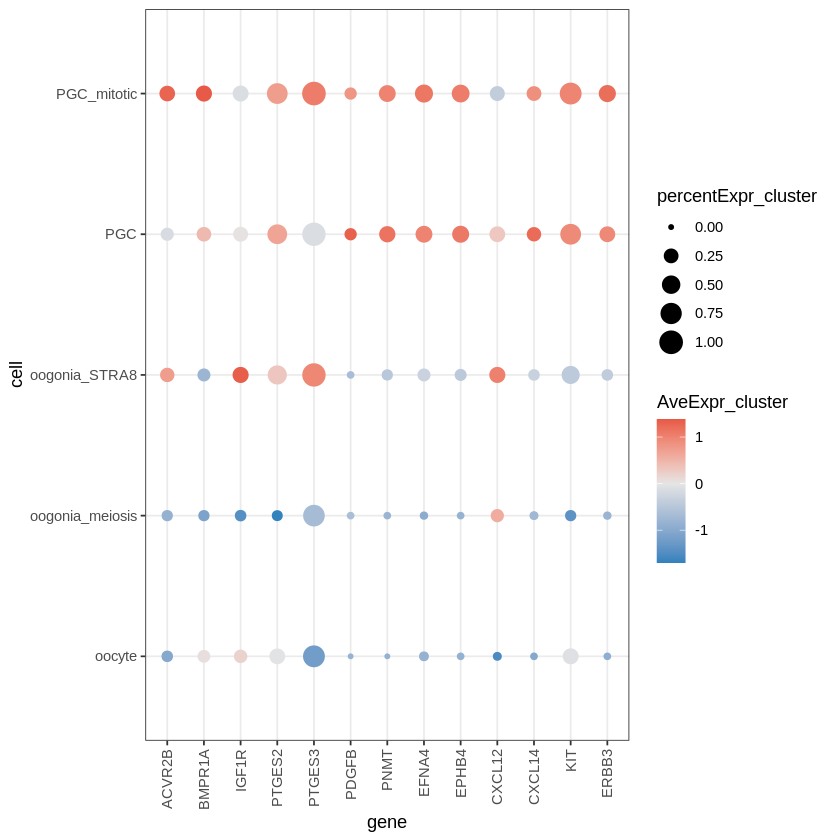

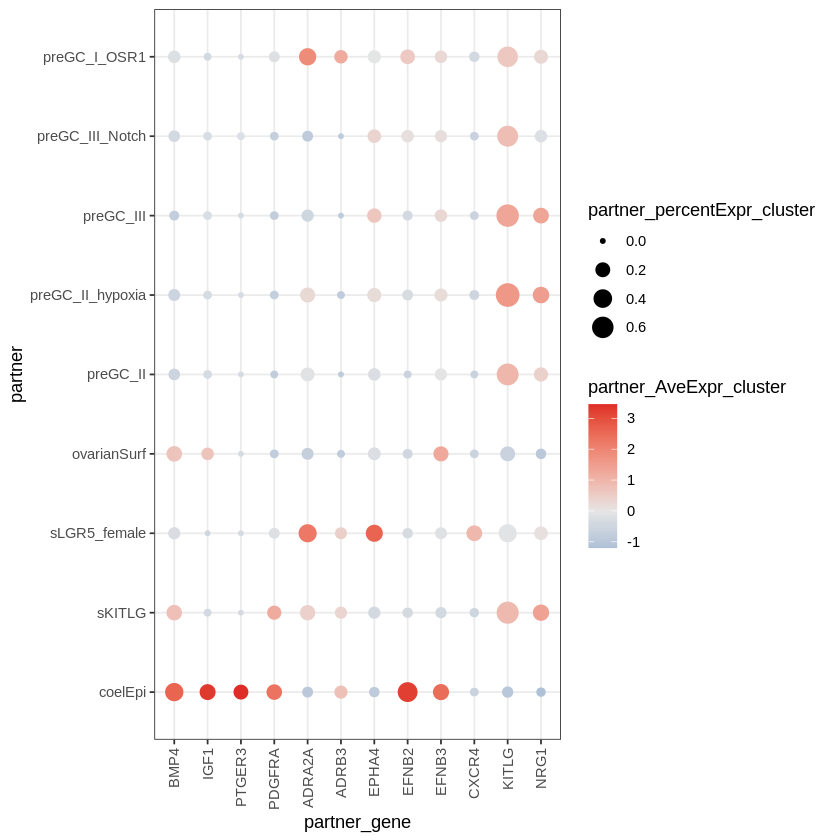

In [11]:
cells = unlist(microenviroments)
    
# cell-cell combinations
comb_of_interest = get_combinations_of_interest(intersect(target_cells, cells), intersect(partner_cells, cells))

# Filter results for comb of interest
fCPresults = CPresults[ , colnames(CPresults) %in% comb_of_interest  ]
fCPresults = fCPresults[ rowSums(fCPresults) > 0,  ]
fCPresults = fCPresults[ , colSums(fCPresults) > 0 ]

# Get plotting data.frame
cells2genes = get_cells2genes(fCPresults, genes2filter = gens_of_interest)


# PLOT target_cells
G_df = subset(cells2genes, gene %in% germ_partners)
G_df = subset(G_df, cell %in% target_cells)
G_df$cell = as.character(G_df$cell)
G_df$gene = as.character(G_df$gene)
G_df$gene = factor(G_df$gene, levels = intersect(germ_partners, G_df$gene))
G_df$cell = factor(G_df$cell, levels = target_cells)
df2plot = G_df[ , names(G_df) %in% c('gene', 'cell', 'AveExpr_cluster', 'percentExpr_cluster') ] %>% unique(.)
ggplot(df2plot,  aes(x = gene,
                     y = cell,
                     color = AveExpr_cluster,
                     size = percentExpr_cluster)) +  
                                  geom_point() + 
                                  scale_color_gradient2(low = brewer.pal(n = 5, name = 'Blues')[4], 
                                                        high = brewer.pal(n = 5, name = 'Reds')[4], 
                                                        mid = 'grey90')+
                                  theme_bw() + 
                                  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1)) 

ggsave(filename = paste0(outdir, 'germs_' , pval_cutoff, '_logFC', logFC_cutoff, '.pdf'), dpi = 300, width = 5.15, height = 2.5)
                        
                                                                    

# PLOT partner cells
# order partners as in previous plot
S_df = subset(cells2genes, partner %in% partner_cells)
S_df = subset(S_df, partner_gene %in% somatic_partners)
# order as in target genes
S_df = do.call(rbind, lapply(levels(G_df$gene), function(i) subset(S_df, gene == i)  ))                                    
S_df$partner_gene = factor(S_df$partner_gene, levels = somatic_partners)
S_df$partner = factor(S_df$partner, levels = partner_cells)
df2plot = S_df[ , names(S_df) %in% c('partner_gene', 'partner', 'partner_AveExpr_cluster', 'partner_percentExpr_cluster') ] %>% unique(.)
ggplot(df2plot,  aes(x = partner_gene,
                     y = partner,
                     color = partner_AveExpr_cluster,
                     size = partner_percentExpr_cluster)) +  
                                  geom_point() + 
                                  scale_color_gradient2(low = brewer.pal(n = 5, name = 'Blues')[4], 
                                                        high = brewer.pal(n = 5, name = 'Reds')[4], 
                                                        mid = 'grey90')+
                                  theme_bw() + 
                                  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1)) 

                                  
ggsave(filename = paste0(outdir, 'soma_' , pval_cutoff, '_logFC', logFC_cutoff, '.pdf'), dpi = 300, width = 5.75, height = 3)                                         
                                    
                                    
cells2genes = subset(cells2genes,  cellphoneDB_hit == 1)
write.csv(cells2genes, file = paste0(outdir, 'germs_' , pval_cutoff, '_logFC', logFC_cutoff, '.csv'))     

In [12]:
receptors2TF = get_receptors2TF(fCPresults, genes2filter = c(germ_partners, somatic_partners) , show_only_selected = T)
unique(subset(receptors2TF, cell %in% germs)[, c('partner',  'cell', 'member_of', 'TF') ])
unique(subset(receptors2TF, cell %in% germs)$TF)
unique(subset(receptors2TF, cell %in% soma)[, c('partner',  'cell', 'member_of', 'TF') ])
unique(subset(receptors2TF, cell %in% soma)$TF)

32 interactions



,partner,cell,member_of,TF
,<chr>,<chr>,<chr>,<chr>
9,coelEpi,PGC,EPHB4,ELK1
10,ovarianSurf,PGC,KIT,STAT1
11,ovarianSurf,PGC,KIT,STAT3
14,preGC_II,PGC,KIT,STAT1
15,preGC_II,PGC,KIT,STAT3
18,preGC_II_hypoxia,PGC,KIT,STAT1
19,preGC_II_hypoxia,PGC,KIT,STAT3
22,sKITLG,PGC,KIT,STAT1
23,sKITLG,PGC,KIT,STAT3


[1] "ELK1"  "STAT1" "STAT3" "SMAD1" "SMAD5" "ZGLP1"

,partner,cell,member_of,TF
,<chr>,<chr>,<chr>,<chr>
110,oocyte,preGC_III,BMPR1B_BMPR2,ZGLP1
142,oogonia_STRA8,preGC_III,BMPR1B_BMPR2,ZGLP1


[1] "ZGLP1"

# PLOT STRA8

In [28]:
germ_partners = c( 'DLL3', 'DLK1',
                 'BMP4',  'ACVR2B', 'BMPR1A',
                  'RBP4', 
                  'ESR1','ESR2','PTH1R', 'RARA', 'CRABP2', 'EPHB2'
#                   'FZD4', 'LRP5', 'LRP6'
                 )


somatic_partners = c('NOTCH2',
                     'ACVR2B', 'BMPR1A','BMPR1B','BMP6', 'BMP2' ,
                     'STRA6', 
                     'CYP19A1', 'HSD17B1','HSD17B6', 'PTHLH' , 'ALDH1A2', 'EFNB1'
#                       'WNT6'
                    )

outdir = 'cellphoneDB/out/figure_STRA8/'
dir.create(outdir, showWarnings = F)

gens_of_interest = rownames(Avg_mat)
target_cells = germs
partner_cells = somaF

In [29]:
G_df = subset(cells2genes, gene %in% germ_partners)
subset(G_df, partner_gene %in% 'HSD17B1')

,cell,gene,interaction,partner,partner_gene,cellphoneDB_hit,id,id_partner,AveExpr_cluster,percentExpr_cluster,partner_AveExpr_cluster,partner_percentExpr_cluster
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
25182,oocyte,ESR2,Estradiol_byHSD17B1_ESR2,preGC_I_OSR1,HSD17B1,1,oocyte ESR2,preGC_I_OSR1 HSD17B1,1.786557,0.17,2.863798,0.47


199 interactions



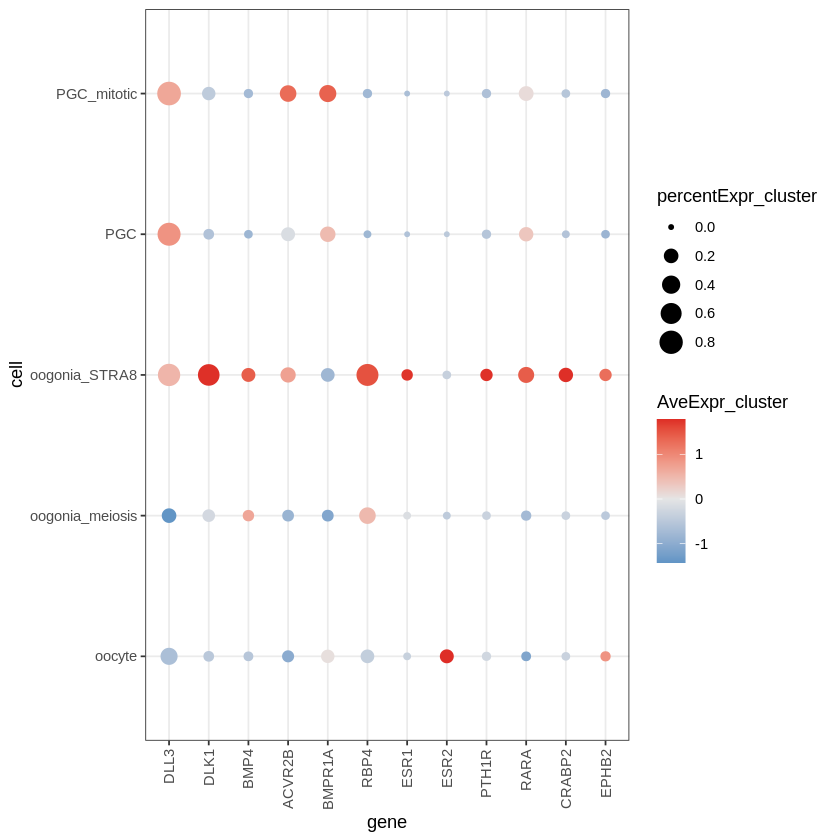

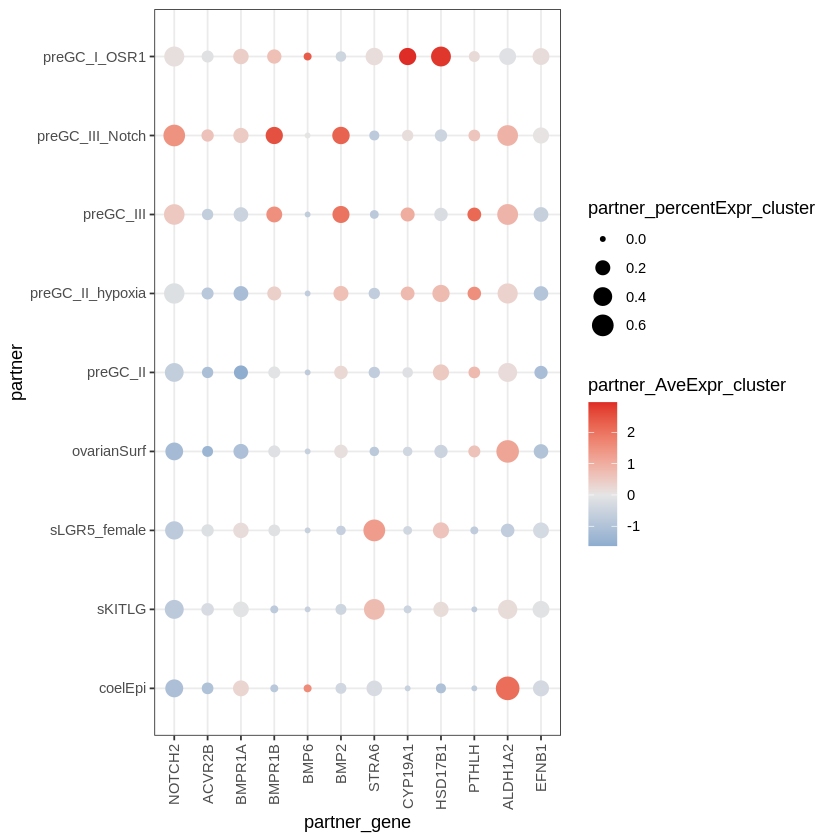

In [30]:
cells = unlist(microenviroments)
    
# cell-cell combinations
comb_of_interest = get_combinations_of_interest(intersect(target_cells, cells), intersect(partner_cells, cells))

# Filter results for comb of interest
fCPresults = CPresults[ , colnames(CPresults) %in% comb_of_interest  ]
fCPresults = fCPresults[ rowSums(fCPresults) > 0,  ]
fCPresults = fCPresults[ , colSums(fCPresults) > 0 ]

# Get plotting data.frame
cells2genes = get_cells2genes(fCPresults, genes2filter = gens_of_interest)


# PLOT target_cells
G_df = subset(cells2genes, gene %in% germ_partners)
G_df = subset(G_df, cell %in% target_cells)
G_df$cell = as.character(G_df$cell)
G_df$gene = as.character(G_df$gene)
G_df$gene = factor(G_df$gene, levels = intersect(germ_partners, G_df$gene))
G_df$cell = factor(G_df$cell, levels = target_cells)
df2plot = G_df[ , names(G_df) %in% c('gene', 'cell', 'AveExpr_cluster', 'percentExpr_cluster') ] %>% unique(.)
ggplot(df2plot,  aes(x = gene,
                     y = cell,
                     color = AveExpr_cluster,
                     size = percentExpr_cluster)) +  
                                  geom_point() + 
                                  scale_color_gradient2(low = brewer.pal(n = 5, name = 'Blues')[4], 
                                                        high = brewer.pal(n = 5, name = 'Reds')[4], 
                                                        mid = 'grey90')+
                                  theme_bw() + 
                                  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1)) 

ggsave(filename = paste0(outdir, 'germs_' , pval_cutoff, '_logFC', logFC_cutoff, '.pdf'), dpi = 300, width = 4.75, height = 2.5)
                        
                                                                    

# PLOT partner cells
# order partners as in previous plot
S_df = subset(cells2genes, partner %in% partner_cells)
S_df = subset(S_df, partner_gene %in% somatic_partners)
# order as in target genes
S_df = do.call(rbind, lapply(levels(G_df$gene), function(i) subset(S_df, gene == i)  ))                                    
S_df$partner_gene = factor(S_df$partner_gene, levels = somatic_partners)
S_df$partner = factor(S_df$partner, levels = partner_cells)
df2plot = S_df[ , names(S_df) %in% c('partner_gene', 'partner', 'partner_AveExpr_cluster', 'partner_percentExpr_cluster') ] %>% unique(.)
ggplot(df2plot,  aes(x = partner_gene,
                     y = partner,
                     color = partner_AveExpr_cluster,
                     size = partner_percentExpr_cluster)) +  
                                  geom_point() + 
                                  scale_color_gradient2(low = brewer.pal(n = 5, name = 'Blues')[4], 
                                                        high = brewer.pal(n = 5, name = 'Reds')[4], 
                                                        mid = 'grey90')+
                                  theme_bw() + 
                                  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1)) 

                                  
ggsave(filename = paste0(outdir, 'soma_' , pval_cutoff, '_logFC', logFC_cutoff, '.pdf'), dpi = 300, width = 5.5, height = 3)                                         
                                    
                                    
cells2genes = subset(cells2genes,  cellphoneDB_hit == 1)
write.csv(cells2genes, file = paste0(outdir, 'germs_' , pval_cutoff, '_logFC', logFC_cutoff, '.csv'))     

In [15]:
receptors2TF = get_receptors2TF(fCPresults, genes2filter = c(germ_partners, somatic_partners) , show_only_selected = T)
unique(subset(receptors2TF, cell %in% germs)[, c('partner',  'cell', 'member_of', 'TF') ])
unique(subset(receptors2TF, cell %in% germs)$TF)
unique(subset(receptors2TF, cell %in% soma)[, c('partner',  'cell', 'member_of', 'TF') ])
unique(subset(receptors2TF, cell %in% soma)$TF)

42 interactions



,partner,cell,member_of,TF
,<chr>,<chr>,<chr>,<chr>
41,preGC_III,oogonia_STRA8,BMPR1B_BMPR2,SMAD1
42,preGC_III,oogonia_STRA8,BMPR1B_BMPR2,SMAD5
44,preGC_III,oogonia_STRA8,BMPR1B_BMPR2,ZGLP1
45,preGC_III,oogonia_STRA8,BMR1A_AVR2B,SMAD1
46,preGC_III,oogonia_STRA8,BMR1A_AVR2B,SMAD5
48,preGC_III,oogonia_STRA8,BMR1A_AVR2B,ZGLP1
49,preGC_III,oogonia_STRA8,BMR1B_AVR2A,SMAD1
50,preGC_III,oogonia_STRA8,BMR1B_AVR2A,SMAD5
52,preGC_III,oogonia_STRA8,BMR1B_AVR2A,ZGLP1


[1] "SMAD1" "SMAD5" "ZGLP1" "ESR2"

,partner,cell,member_of,TF
,<chr>,<chr>,<chr>,<chr>
228,oocyte,preGC_III,BMPR1B_BMPR2,ZGLP1
287,oogonia_STRA8,preGC_III,BMPR1B_BMPR2,ZGLP1
332,oocyte,preGC_III_Notch,NOTCH3,RBPJ
337,oogonia_STRA8,preGC_III_Notch,NOTCH3,RBPJ
339,oogonia_meiosis,preGC_III_Notch,NOTCH3,RBPJ


[1] "ZGLP1" "RBPJ"

# PLOT Folliculogenesis

In [16]:
germ_partners = c('CYP11A1', 'BMP6', 'GDF9', 'JAG1', 'SIRPA', 'HDC', 'NRG4', 'ALDH1A', 'DCC' )


somatic_partners = c('NR1H4', 'BMPR2', 'BMPR1A', 'BMPR1B', 'ACVR2B', 'TGFBR1', 'NOTCH2', 'NOTCH3', 'CD46', 'HRH1', 'ERBB4', 'NTN1')

outdir = 'cellphoneDB/out/figure_folliculogenesis/'
dir.create(outdir, showWarnings = F)

gens_of_interest = rownames(Avg_mat)
target_cells = germs
partner_cells = somaF

199 interactions



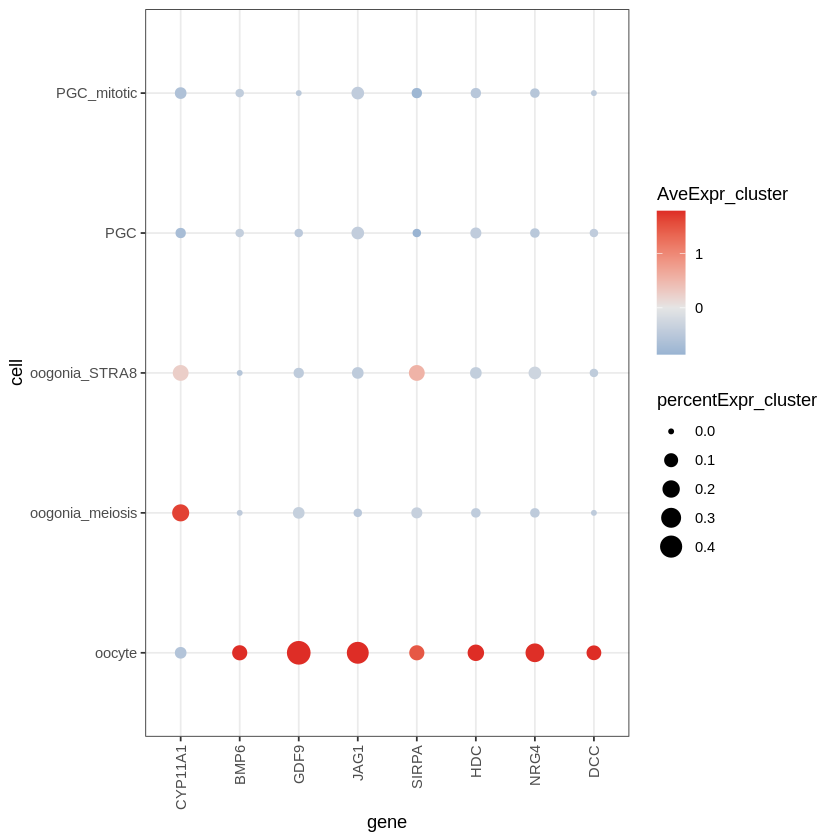

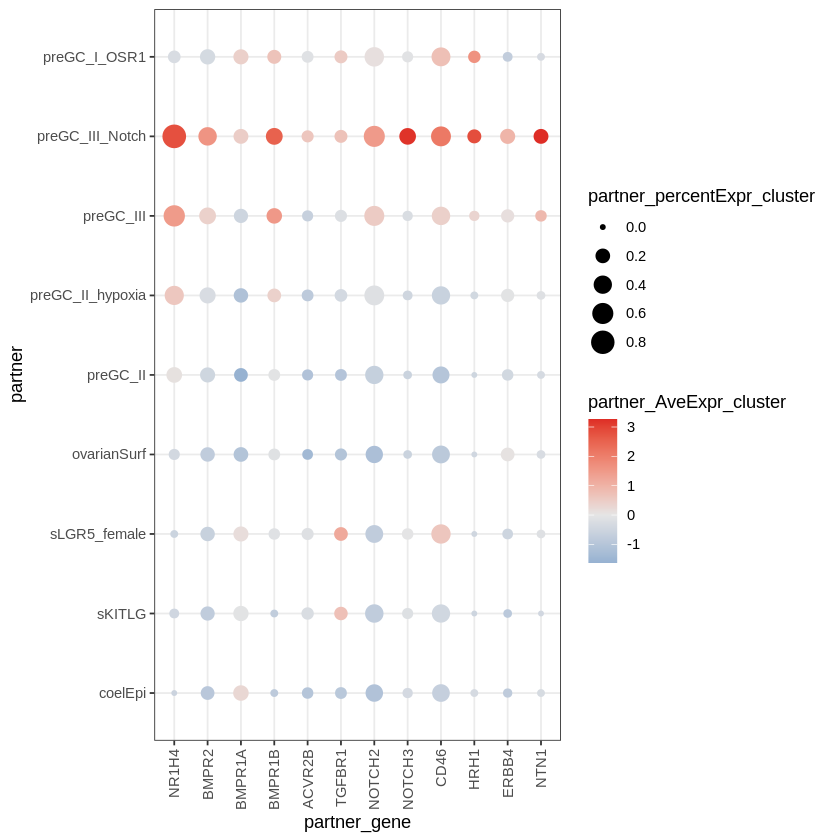

In [17]:
cells = unlist(microenviroments)
    
# cell-cell combinations
comb_of_interest = get_combinations_of_interest(intersect(target_cells, cells), intersect(partner_cells, cells))

# Filter results for comb of interest
fCPresults = CPresults[ , colnames(CPresults) %in% comb_of_interest  ]
fCPresults = fCPresults[ rowSums(fCPresults) > 0,  ]
fCPresults = fCPresults[ , colSums(fCPresults) > 0 ]

# Get plotting data.frame
cells2genes = get_cells2genes(fCPresults, genes2filter = gens_of_interest)


# PLOT target_cells
G_df = subset(cells2genes, gene %in% germ_partners)
G_df = subset(G_df, cell %in% target_cells)
G_df$cell = as.character(G_df$cell)
G_df$gene = as.character(G_df$gene)
G_df$gene = factor(G_df$gene, levels = intersect(germ_partners, G_df$gene))
G_df$cell = factor(G_df$cell, levels = target_cells)
df2plot = G_df[ , names(G_df) %in% c('gene', 'cell', 'AveExpr_cluster', 'percentExpr_cluster') ] %>% unique(.)
ggplot(df2plot,  aes(x = gene,
                     y = cell,
                     color = AveExpr_cluster,
                     size = percentExpr_cluster)) +  
                                  geom_point() + 
                                  scale_color_gradient2(low = brewer.pal(n = 5, name = 'Blues')[4], 
                                                        high = brewer.pal(n = 5, name = 'Reds')[4], 
                                                        mid = 'grey90')+
                                  theme_bw() + 
                                  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1)) 

ggsave(filename = paste0(outdir, 'germs_' , pval_cutoff, '_logFC', logFC_cutoff, '.pdf'), dpi = 300, width = 4.5, height = 2.5)
                        
                                                                    

# PLOT partner cells
# order partners as in previous plot
S_df = subset(cells2genes, partner %in% partner_cells)
S_df = subset(S_df, partner_gene %in% somatic_partners)
# order as in target genes
S_df = do.call(rbind, lapply(levels(G_df$gene), function(i) subset(S_df, gene == i)  ))                                    
S_df$partner_gene = factor(S_df$partner_gene, levels = unique(S_df$partner_gene))                                 
S_df$partner_gene = factor(S_df$partner_gene, levels = somatic_partners)
S_df$partner = factor(S_df$partner, levels = partner_cells)
df2plot = S_df[ , names(S_df) %in% c('partner_gene', 'partner', 'partner_AveExpr_cluster', 'partner_percentExpr_cluster') ] %>% unique(.)
ggplot(df2plot,  aes(x = partner_gene,
                     y = partner,
                     color = partner_AveExpr_cluster,
                     size = partner_percentExpr_cluster)) +  
                                  geom_point() + 
                                  scale_color_gradient2(low = brewer.pal(n = 5, name = 'Blues')[4], 
                                                        high = brewer.pal(n = 5, name = 'Reds')[4], 
                                                        mid = 'grey90')+
                                  theme_bw() + 
                                  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1)) 

                                  
ggsave(filename = paste0(outdir, 'soma_' , pval_cutoff, '_logFC', logFC_cutoff, '.pdf'), dpi = 300, width = 5.5, height = 3)                                         
                                    
                                    
cells2genes = subset(cells2genes,  cellphoneDB_hit == 1)
write.csv(cells2genes, file = paste0(outdir, 'germs_' , pval_cutoff, '_logFC', logFC_cutoff, '.csv'))     

In [18]:
receptors2TF = get_receptors2TF(fCPresults, genes2filter = c(germ_partners, somatic_partners) , show_only_selected = T)
unique(subset(receptors2TF, cell %in% germs)[, c('partner',  'cell', 'member_of', 'TF') ])
unique(subset(receptors2TF, cell %in% germs)$TF)
unique(subset(receptors2TF, cell %in% soma)[, c('partner',  'cell', 'member_of', 'TF') ])
unique(subset(receptors2TF, cell %in% soma)$TF)

32 interactions



,partner,cell,member_of,TF
,<chr>,<chr>,<chr>,<chr>
41,preGC_III,oogonia_STRA8,BMPR1B_BMPR2,SMAD1
42,preGC_III,oogonia_STRA8,BMPR1B_BMPR2,SMAD5
44,preGC_III,oogonia_STRA8,BMPR1B_BMPR2,ZGLP1
45,preGC_III,oogonia_STRA8,BMR1A_AVR2B,SMAD1
46,preGC_III,oogonia_STRA8,BMR1A_AVR2B,SMAD5
48,preGC_III,oogonia_STRA8,BMR1A_AVR2B,ZGLP1
49,preGC_III,oogonia_STRA8,BMR1B_AVR2A,SMAD1
50,preGC_III,oogonia_STRA8,BMR1B_AVR2A,SMAD5
52,preGC_III,oogonia_STRA8,BMR1B_AVR2A,ZGLP1


[1] "SMAD1" "SMAD5" "ZGLP1"

,partner,cell,member_of,TF
,<chr>,<chr>,<chr>,<chr>
116,oocyte,preGC_III,BMPR1B_BMPR2,ZGLP1
166,oogonia_STRA8,preGC_III,BMPR1B_BMPR2,ZGLP1
179,oogonia_STRA8,preGC_III_Notch,NOTCH3,RBPJ
213,oocyte,preGC_III_Notch,NOTCH3,RBPJ
223,oogonia_meiosis,preGC_III_Notch,NOTCH3,RBPJ


[1] "ZGLP1" "RBPJ"